# Загрузка

In [19]:
target = df_hardness.columns[-3:]

In [228]:
ls_columns_output = [
#     '№ партии',
#     '№ плавки',
    'марка стали',
    'диаметр',
    'толщина стенки',
    'Гр. прочн.',
    '1 зона по ВТР закалка',
    '2 зона по ВТР закалка',
    '3 зона по ВТР закалка',
    'шаг балок закалочная печь, сек',
    'Скорость прохождения трубы через спрейер, м/с', 
    't˚ C трубы после спреера',
    '1 зона ВТР и уставка отпуск', 
    '2 зона ВТР и уставка отпуск', 
    '3 зона ВТР и уставка отпуск',
    '4 зона ВТР и уставка отпуск',
    '5 зона ВТР и уставка отпуск',
    'шаг балок отпускная печь, сек',
    'C',
    'Mn',
    'Si',
    'P',
    'S',
    'Cr',
    'Ni',
    'Cu',
    'Al',
    'V',
    'Ti',
    'Nb',
    'Mo',
    'N',
    'B',
    'C-coef',
    'Параметр закалка',
    'Параметр отпуск',
    'Параметр отпуск новый V',
    'Величина зерна',
    'Тип предела текучести (1186)',
#     'Дата термообработки',
    'ICD',
#     'Примечание',
    'длина трубы',
    'Предел текучести',
    'Врем. сопротивление'
    ]

In [229]:
import pandas as pd
import numpy as np
import import_ipynb
from my_libs.calc_features import *
import random
from datetime import datetime

In [230]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 1000

In [231]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [232]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, matthews_corrcoef, median_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, cross_validate, train_test_split, GridSearchCV
from sklearn import model_selection
import matplotlib.pyplot as plt
import os
from time import time
from datetime import datetime
from my_libs.save_lib import save_RF_model
from scipy.stats.stats import pearsonr

In [317]:
df = pd.read_csv('DATA/prepared/prepared_to_saw_gp.csv', low_memory=False)

In [318]:
df_hardness = pd.read_excel('DATA/source/exp/prepared/table_hardness_api.xlsx')

In [319]:
df_hardness.columns[-3:]

Index(['Число твердости на середине поверхности (1148)',
       'Число твердости на внутренней поверхности (1149)',
       'Число твердости у наружной поверхности (1147)'],
      dtype='object')

In [320]:
['№ плавки', '№ партии'] + list(df_hardness.columns[-3:])

['№ плавки',
 '№ партии',
 'Число твердости на середине поверхности (1148)',
 'Число твердости на внутренней поверхности (1149)',
 'Число твердости у наружной поверхности (1147)']

In [321]:
df_hardness = df_hardness[['№ плавки', '№ партии'] + list(df_hardness.columns[-3:])]

In [322]:
df_hardness.shape

(3090, 5)

In [323]:
df_hardness = df_hardness.groupby(['№ плавки', '№ партии'])[list(df_hardness.columns[-3:])].mean()

In [324]:
df_hardness = pd.DataFrame(df_hardness)

In [325]:
df_hardness.reset_index(inplace=True)

In [326]:
df_hardness.shape

(3089, 5)

In [327]:
df_hardness['№ плавки'] = df_hardness['№ плавки'].astype(str)
df_hardness['№ плавки'] = df_hardness['№ плавки'].apply(lambda x: x.lower())
df_hardness['№ партии'] = df_hardness['№ партии'].astype(str)
df['№ плавки'] = df['№ плавки'].astype(str)
df['№ плавки'] = df['№ плавки'].apply(lambda x: x.lower())
df['№ партии'] = df['№ партии'].astype(str)

In [328]:
df_ = pd.merge(df, df_hardness, on=['№ плавки', '№ партии'], how='left')
df_.shape

(24503, 204)

In [329]:
def bath2spr(df):
    L = 8.4
    df['Скорость прохождения трубы через спрейер, м/с'] = L/df['время выдержки в закалочной ванне, сек.']
    df['t˚ C трубы после спреера'] = df['t˚ C трубы после ванны']
    return df

In [330]:
bath = df_[~df_['время выдержки в закалочной ванне, сек.'].isnull()].copy()
df_ = df_[df_['время выдержки в закалочной ванне, сек.'].isnull()].copy()


bath = bath2spr(bath)

df = pd.concat([df_, bath])
df.reset_index(inplace=True, drop=True)

In [331]:
df.shape

(24503, 204)

In [332]:
df = len_pipe(df)

df = mean_chem(df)

df = calc_all_features(df)

In [333]:
df = df[df['шаг балок закалочная печь, сек'] < 100]
df = df[df['шаг балок закалочная печь, сек'] >= 24]
df = df[df['шаг балок отпускная печь, сек'] >= 24]
df = df[df['Скорость прохождения трубы через спрейер, м/с'] <= 1]
df = df[df['t˚ C трубы после спреера'] > 1]
df = df[df['t˚ C трубы после спреера'] <= 250]
df = df[df['2 зона ВТР и уставка отпуск'] > 400]
df = df[df['4 зона ВТР и уставка отпуск'] > 400]

In [334]:
df.shape

(23716, 205)

In [335]:
df['Дата термообработки'] = df['Дата термообработки'].apply(lambda x: str(x).replace(' 00:00:00', ''))
df['Дата термообработки'] = df['Дата термообработки'].apply(lambda x: str(x).replace('-', '.'))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D0C4A58>,
      dtype=object)

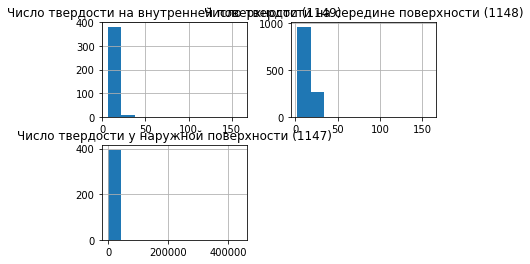

In [336]:
df[target].hist()

In [337]:
df[target].describe()

,Число твердости на середине поверхности (1148),Число твердости на внутренней поверхности (1149),Число твердости у наружной поверхности (1147)
count,1231.000000,390.000000,396.000000
mean,15.410317,17.558462,1140.664899
std,5.701051,7.825607,22159.867019
min,2.500000,7.000000,6.000000
25%,13.500000,16.000000,15.500000
50%,16.000000,17.750000,18.000000
75%,18.000000,19.000000,19.925000
max,158.700000,160.100000,440995.000000


In [673]:
target

Index(['Число твердости на середине поверхности (1148)',
       'Число твердости на внутренней поверхности (1149)',
       'Число твердости у наружной поверхности (1147)'],
      dtype='object')

In [723]:
set(target) - set(target[:-1])

{'Число твердости у наружной поверхности (1147)'}

In [724]:
tar = list(set(target) - set(target[:-1]))

In [725]:
tar

['Число твердости у наружной поверхности (1147)']

In [726]:
tmp = []
for x in df['Дата термообработки']:
    try:
        tmp.append(datetime.strptime(x, "%d.%m.%Y"))
    except ValueError:
        tmp.append(datetime.strptime(x, "%Y.%m.%d"))
    except TypeError:
        pass
    
# df['Дата термообработки'] = tmp

In [727]:
df_prepared = df.copy()
df_train = df_prepared.copy()

In [728]:
ls_train = ls_columns_output.copy()
# ls_train.remove('Дата термообработки')
ls_train.remove('марка стали')
ls_train.remove('Гр. прочн.')

ls_to_del = []

In [729]:
ls_train = list(set(ls_train) - set(ls_to_del))

In [730]:
df_train[ls_train+tar].dropna().shape

(396, 40)

In [731]:
df_train[ls_train+tar].dropna().drop_duplicates().shape

(396, 40)

In [732]:
df_train = df_train[ls_train+tar].dropna()

df_train.drop_duplicates(inplace=True)

X, X_valid, y, y_valid = train_test_split(df_train[ls_train], df_train[tar], test_size=0.2, shuffle=True)

In [733]:
X.shape, X_valid.shape

((316, 39), (80, 39))

In [734]:
X.columns

Index(['2 зона по ВТР закалка', 'Параметр отпуск', 'V', 'N',
       '1 зона ВТР и уставка отпуск', 'Si', 'Параметр отпуск новый V', 'Nb',
       'Тип предела текучести (1186)', '5 зона ВТР и уставка отпуск',
       't˚ C трубы после спреера', 'Mo', 'шаг балок отпускная печь, сек',
       'Предел текучести', 'Ti', 'S', 'Cu', 'толщина стенки', 'C-coef',
       '3 зона по ВТР закалка', 'C',
       'Скорость прохождения трубы через спрейер, м/с', 'Mn', 'диаметр', 'P',
       'Ni', 'Параметр закалка', '4 зона ВТР и уставка отпуск', 'Cr',
       '1 зона по ВТР закалка', 'Al', 'шаг балок закалочная печь, сек',
       '3 зона ВТР и уставка отпуск', 'B', '2 зона ВТР и уставка отпуск',
       'Врем. сопротивление', 'длина трубы', 'ICD', 'Величина зерна'],
      dtype='object')

In [735]:
def print_and_return_score(x, y, est, verb=1):
    y_pred = est.predict(x)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
#     corr = np.corrcoef(y.T,y_pred)
    
    if verb==1:        
        print('R^2: ', round(r2, 2))
        print('MAE: ', round(mae, 2))
        print('MSE: ', round(mse, 2))
#         print('Correlation1: ', round(corr[0][1], 2))
    return [mae, mse]

In [736]:
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [737]:
len(ls_train)

39

In [743]:
rfc = RandomForestRegressor(max_features = 12, max_depth = 18, min_samples_leaf = 1, n_estimators=50, criterion='mse')
rfc.fit(X_train, y_train)

mae, mse = print_and_return_score(X_test, y_test, rfc)

R^2:  -2050.79
MAE:  2531.13
MSE:  206738517.02


D:\Repo\Anaconda2\envs\myenv\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [700]:
val = rfc.feature_importances_
lab = ls_train
dict_feat_import = dict(zip(lab, val))
ls_to_del = []
for feat, imp in zip(lab, val):
    print(feat, '  ', imp.round(2))
    if imp.round(2) < 0.01:
        ls_to_del.append(feat)

2 зона по ВТР закалка    0.0
Параметр отпуск    0.02
V    0.02
N    0.02
1 зона ВТР и уставка отпуск    0.02
Si    0.03
Параметр отпуск новый V    0.08
Nb    0.01
Тип предела текучести (1186)    0.0
5 зона ВТР и уставка отпуск    0.02
t˚ C трубы после спреера    0.03
Mo    0.01
шаг балок отпускная печь, сек    0.0
Предел текучести    0.08
Ti    0.02
S    0.02
Cu    0.02
толщина стенки    0.0
C-coef    0.04
3 зона по ВТР закалка    0.0
C    0.02
Скорость прохождения трубы через спрейер, м/с    0.03
Mn    0.03
диаметр    0.0
P    0.02
Ni    0.02
Параметр закалка    0.01
4 зона ВТР и уставка отпуск    0.01
Cr    0.03
1 зона по ВТР закалка    0.0
Al    0.02
шаг балок закалочная печь, сек    0.02
3 зона ВТР и уставка отпуск    0.02
B    0.0
2 зона ВТР и уставка отпуск    0.01
Врем. сопротивление    0.14
длина трубы    0.04
ICD    0.08
Величина зерна    0.06


In [701]:
ls_to_del

['2 зона по ВТР закалка',
 'Тип предела текучести (1186)',
 'шаг балок отпускная печь, сек',
 'толщина стенки',
 '3 зона по ВТР закалка',
 'диаметр',
 '1 зона по ВТР закалка',
 'B']

In [702]:
from sklearn.ensemble import GradientBoostingRegressor

g = GradientBoostingRegressor()
g.fit(X_train, y_train)

mae, mse = print_and_return_score(X_test, y_test, g)

ValueError: bad input shape (249, 2)

In [630]:
# import tensorflow as tf
import theano
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization

In [631]:
model = Sequential()
model.add(Dense(units=128,input_dim=X_train.shape[1]))
model.add(Activation('softmax'))
model.add(Dropout(0.5))
model.add(Dense(units=3))
model.compile(
        loss=keras.losses.mean_squared_error,
        metrics=[keras.metrics.mean_absolute_error],
#             optimizer=keras.optimizers.SGD(lr=0.05, momentum=0.6, decay=1e-7, nesterov=True)
#             optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.85, beta_2=0.98, epsilon=1e-7, decay=1e-7, amsgrad=True)
#         optimizer=keras.optimizers.RMSprop(lr=0.01, rho=0.8, epsilon=None, decay=0.0)
#     optimizer=keras.optimizers.SGD(lr=0.001, momentum = 0.8, decay=1e-6)
    optimizer = keras.optimizers.Nadam(lr=0.003, beta_1=0.99, beta_2=0.999, epsilon=None, schedule_decay=0.005)
        )

model.fit(X_train, y_train, batch_size = 512, epochs=10, shuffle=True)

y_pred = model.predict(X_test)
print('mae =', mean_absolute_error(y_test, y_pred))
print('mse = ', mean_squared_error(y_test, y_pred))
print('r2 = ', r2_score(y_test, y_pred))

Epoch 1/10
249/249 [==============================] - 0s 24us/step - loss: 826.8831 - mean_absolute_error: 18.3018
Epoch 2/10
249/249 [==============================] - 0s 173us/step - loss: 826.3948 - mean_absolute_error: 18.2881
Epoch 3/10
249/249 [==============================] - 0s 24us/step - loss: 826.6991 - mean_absolute_error: 18.2866
Epoch 4/10
249/249 [==============================] - 0s 32us/step - loss: 826.5725 - mean_absolute_error: 18.2835
Epoch 5/10
249/249 [==============================] - 0s 28us/step - loss: 826.0366 - mean_absolute_error: 18.2784
Epoch 6/10
249/249 [==============================] - 0s 24us/step - loss: 826.3450 - mean_absolute_error: 18.2763
Epoch 7/10
249/249 [==============================] - 0s 96us/step - loss: 825.7180 - mean_absolute_error: 18.2697
Epoch 8/10
249/249 [==============================] - 0s 36us/step - loss: 826.1477 - mean_absolute_error: 18.2707
Epoch 9/10
249/249 [==============================] - 0s 24us/step - loss: 825.

In [659]:
y_pred = model.predict(X_test)
print('mae =', mean_absolute_error(y_test, y_pred))
print('mse = ', mean_squared_error(y_test, y_pred))
print('r2 = ', r2_score(y_test, y_pred))

ValueError: y_true and y_pred have different number of output (1!=3)

In [440]:
X_train.corrwith(y_train).sort_values()

Скорость прохождения трубы через спрейер, м/с   -0.387310
Величина зерна                                  -0.226242
C-coef                                           0.047758
t˚ C трубы после спреера                         0.145830
3 зона ВТР и уставка отпуск                      0.179295
Параметр отпуск новый V                          0.186491
длина трубы                                      0.223164
Предел текучести                                 0.271351
Параметр отпуск                                  0.299864
ICD                                              0.320091
Врем. сопротивление                              0.324790
шаг балок закалочная печь, сек                   0.338561
Cr                                               0.368641
dtype: float64

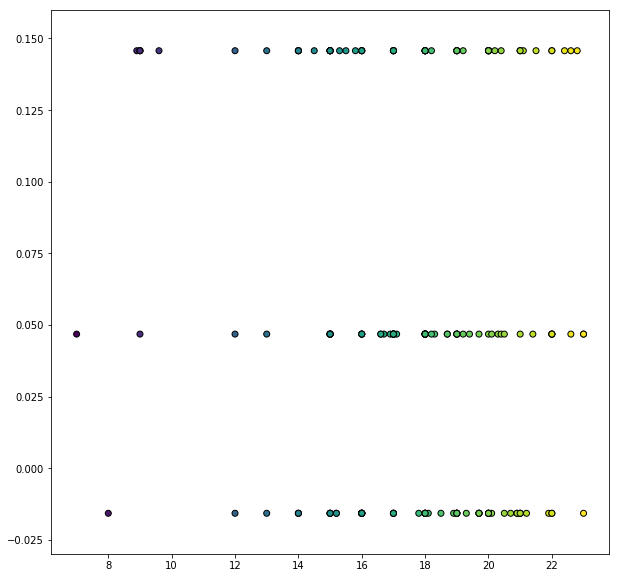

In [633]:
y_pred = model.predict(X_test)
plt.subplots(figsize=(10,10))
plt.scatter(y_test, y_pred, marker='o', c=y_test, edgecolors='black', cmap='viridis')
# plt.colorbar()
plt.show()

## GridSearchCV

In [242]:
param_grid = {
    'max_depth': range(6, 18, 2),
    'max_features': range(6, 18, 2),
    'min_samples_leaf': range(1, 5),
    'n_estimators': range(50, 300, 50)
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='neg_mean_absolute_error')

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [244]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 23.7min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(6, 18, 2), 'max_features': range(6, 18, 2), 'min_samples_leaf': range(1, 5), 'n_estimators': range(50, 300, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=2)

In [245]:
grid_search.best_params_

{'max_depth': 16,
 'max_features': 16,
 'min_samples_leaf': 2,
 'n_estimators': 250}

In [658]:
scr, mae, mse, corr, y_pred = print_and_return_score(X_test, y_test, grid_search)

NameError: name 'grid_search' is not defined

In [247]:
y_predict = grid_search.predict(X_test)

## Cross-validation with KFold

In [448]:
kfold = model_selection.KFold(n_splits=5, shuffle=True)
scores = []
for train, test in kfold.split(X, y):
    x_train, y_train = X.iloc[train], y.iloc[train]
    x_test, y_test = X.iloc[test], y.iloc[test]
    grf = rfc
#     grf = grid_search.best_estimator_
    grf.fit(x_train, y_train)

    scores.append(print_and_return_score(X_valid, y_valid, grf))

R^2:  0.03
MAE:  3.02
MSE:  97.38
Correlation1:  0.2
R^2:  0.02
MAE:  3.12
MSE:  98.52
Correlation1:  0.18
R^2:  0.03
MAE:  3.22
MSE:  98.23
Correlation1:  0.19
R^2:  0.03
MAE:  3.09
MSE:  98.04
Correlation1:  0.19
R^2:  0.01
MAE:  3.25
MSE:  99.48
Correlation1:  0.16


In [451]:
for i in range(3):
    tmp = []
    for j in range(3):
        tmp.append(scores[j][i])
    print(round(np.mean(tmp), 2))

3.12
98.04
0.19


In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
grf = grid_search.best_estimator_
grf.fit(X_train, y_train)
scr, mae, mse, corr1, corr2 = print_and_return_score(X_test, y_test, grf)

Score:  0.89
R^2:  0.89
MAE:  2.01
MSE:  8.75
Correlation Врем. сопротивление:  0.95
Correlation Предел текучести:  0.94


In [306]:
y_pred = pd.DataFrame(rfc.predict(X_valid), columns=['прогноз Врем. сопротивление', 'прогноз Предел текучести'])
y_pred.reset_index(inplace=True, drop=True)
y_valid.reset_index(inplace=True, drop=True)

scr, mae, mse, corr1, corr2 = print_and_return_score(X_valid, y_valid, rfc)

score_df = pd.concat([pd.DataFrame({'Score':[scr], 'MAE':[mae], 'MSE':[mse], 'Correlation Врем. сопротивление':[corr1],
                                                     'Correlation Предел текучести':[corr2]}),
                      y_pred,
                      y_valid],
                    axis=1)

score_df['MAE Предел текучести'] = np.abs(score_df['Предел текучести'] - score_df['прогноз Предел текучести'])
score_df['MAE Врем. сопротивление'] = np.abs(score_df['Врем. сопротивление'] - score_df['прогноз Врем. сопротивление'])

Score:  0.9
R^2:  0.9
MAE:  2.85
MSE:  15.05
Correlation Врем. сопротивление:  0.96
Correlation Предел текучести:  0.95


In [270]:
y_pred = pd.DataFrame(grf.predict(X_valid), columns=['прогноз Врем. сопротивление', 'прогноз Предел текучести'])
y_pred.reset_index(inplace=True, drop=True)
y_valid.reset_index(inplace=True, drop=True)

scr, mae, mse, corr1, corr2 = print_and_return_score(X_valid, y_valid, grf)

score_df = pd.concat([pd.DataFrame({'Score':[scr], 'MAE':[mae], 'MSE':[mse], 'Correlation Врем. сопротивление':[corr1],
                                                     'Correlation Предел текучести':[corr2]}),
                      y_pred,
                      y_valid],
                    axis=1)

score_df['MAE Предел текучести'] = np.abs(score_df['Предел текучести'] - score_df['прогноз Предел текучести'])
score_df['MAE Врем. сопротивление'] = np.abs(score_df['Врем. сопротивление'] - score_df['прогноз Врем. сопротивление'])

Score:  0.9
R^2:  0.9
MAE:  2.81
MSE:  14.52
Correlation Врем. сопротивление:  0.96
Correlation Предел текучести:  0.95


In [275]:
save_RF_model(grf, ls_train_col, 'H+YS with Bath', score_df)

Модель сохранена
